In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib.patches import Ellipse
import heartpy as hp
import os
import pickle
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [2]:
def plt_performance(history, path='./', filename=''):
    epoch = list(range(0,len(history.history['loss'])))
    
    fig, (his_accuracy, his_loss) = plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
    his_loss.plot(epoch, history.history['loss'], label='Training loss')
    his_loss.plot(epoch, history.history['val_loss'], label='Validation loss')
    his_loss.set_xlabel("Epochs", fontsize=14)
    his_loss.set_ylabel("Loss", fontsize=14)
    his_loss.set_title("Loss", fontsize=14)
    his_loss.legend(loc='best')
    
    his_accuracy.plot(epoch, history.history['acc'], label='Training accuracy')
    his_accuracy.plot(epoch, history.history['val_acc'], label='Validation accuracy')
    his_accuracy.set_xlabel("Epochs", fontsize=14)
    his_accuracy.set_ylabel("Accuracy", fontsize=14)
    his_accuracy.set_title("Accuracy", fontsize=14)
    his_accuracy.legend(loc='best')
    
    fig.tight_layout()
    if filename == '':
        plt.savefig(f'{path}/performance.png', bbox_inches='tight')
    else:
        plt.savefig(f'{path}/{filename}.png', bbox_inches='tight')
        
# def preprocessing(ppg_data, view = False, participant = ''):
#     # moving average function
#     m_avg = lambda t, x, w : (np.asarray([t[i] for i in range(w, len(x) - w)]),
#                           np.convolve(x, np.ones((2*w + 1, )) / (2*w + 1),
#                                       mode = 'valid'))

#     fs = len(ppg_data)/(60)  # sample rate

#     # moving average
#     w_size = int(fs*.5)  # width of moving window
#     times = list(range(0,len(ppg_data)))
#     mt, ms = m_avg(times, ppg_data, w_size)

#     sign = (ppg_data[w_size:-w_size]-ms)

#     analytical_signal = np.abs(signal.hilbert(sign))

#     fs = len(sign) / (max(mt) - min(mt))
#     w_size = int(fs)
#     mt_new, mov_avg = m_avg(mt, analytical_signal, w_size)

#     signal_pure = sign[w_size : -w_size] / mov_avg
    
#     if view:
#         plt.ioff()
        
#         fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10, 8), sharex=True)
#         ax1.plot(times, ppg_data, "b-", label="Original")
#         ax1.legend(loc='best')
#         ax1.set_title("participants"+str(participant)+" Raw", fontsize=14)#, fontweight="bold")

#         ax2.plot(mt, sign, 'r-', label="Pure signal")
#         ax2.plot(mt_new, mov_avg, 'b-', label='Modulation', alpha=.5)
#         ax2.legend(loc='best')
#         ax2.set_title("Raw -> filtered", fontsize=14)#, fontweight="bold")

#         ax3.plot(mt_new, signal_pure, "g-", label="Demodulated")
#         ax3.set_xlim(0, mt[-1])
#         ax3.set_title("Raw -> filtered -> demodulated", fontsize=14)#, fontweight="bold")

#         ax3.set_xlabel("Time (sec)", fontsize=14) # common axis label
#         ax3.legend(loc='best')

#         fig.tight_layout()
#         plt.savefig(f'./plot_img/{participant}.png', bbox_inches='tight')
        
#     return signal_pure
        
def preprocessing(PPG_data):
    index = 0
    x = list(range(0,len(PPG_data[0])))
    for PPG in PPG_data:
        poly = np.polyfit(x, PPG, deg=50)
        polied = np.polyval(poly, x)
        detrended = PPG - polied
        PPG_data[index] = detrended
        index += 1
    return PPG_data
    
def get_peaks(ppg_processed):
    diff_sig_2 = np.diff(ppg_processed) ## do
    peaks_2, _ = find_peaks(diff_sig_2, distance=100*(30/60), prominence=0.01)
    result = []
    peaks = []
    for i in range(len(peaks_2)):
        if diff_sig_2[peaks_2][i] > 40:
            result.append(peaks_2[i])
            peaks.append(diff_sig_2[peaks_2][i])
            
    return result, peaks, diff_sig_2

In [3]:
dir_list_ = os.listdir("./data")
dir_list_.sort()
count = 0
dir_list = []
# dir_list_.pop(0)
for i in range(20):
    dir_list.append(dir_list_[i])
    
print(dir_list)
df_PPG = pd.DataFrame(columns=['participant','video_number','ppg','valence','arousal'])
Valence_data = []
Arousal_data = []
PPG_data = []

file_num = 0
for file in dir_list:
    dat_file = f'./data/{file}'
    with open(dat_file, 'rb') as f:
        Channel_data = pickle.load(f,encoding='latin1')
    data = Channel_data["data"]
    labels = Channel_data["labels"]
    for video_num in range(40):
        dataP = data[video_num,38]
        dataP = dataP[384:]
        
        label = labels[video_num]
        if label[0] < 5:
            Valence = 0
        if label[0] >= 5:
            Valence = 1
        if label[1] < 5:
            Arousal = 0
        if label[1] >= 5:
            Arousal = 1
        # instance = [(file_num, video_num, dataP, Valence, Arousal)]
        # new_instance = pd.DataFrame(instance, columns=['participant','video_number','ppg','valence','arousal'])
        # df_PPG = pd.concat([df_PPG, new_instance], ignore_index = True)
        PPG_data.append(dataP)
        Valence_data.append(Valence)
        Arousal_data.append(Arousal)
    file_num += 1

['s01.dat', 's02.dat', 's03.dat', 's04.dat', 's05.dat', 's06.dat', 's07.dat', 's08.dat', 's09.dat', 's10.dat', 's11.dat', 's12.dat', 's13.dat', 's14.dat', 's15.dat', 's16.dat', 's17.dat', 's18.dat', 's19.dat', 's20.dat']


In [4]:
preprocessed = preprocessing(PPG_data)
# preprocessed = []
# for PPG in PPG_data:
#     preprocessed.append(preprocessing(PPG))

/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/numpy/lib/polynomial.py:627: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [5]:
import neurokit2.ppg.ppg_findpeaks as findpeaks

{'PPG_Peaks': array([ 110,  235,  362,  483,  601,  721,  837,  953, 1075, 1190, 1311,
       1430, 1534, 2008, 2094, 2199, 2313, 2432, 2818, 2951, 3067, 3191,
       3315, 3436, 3550, 3665, 3783, 3894, 4005, 4121, 4241, 4358, 4484,
       4604, 4723, 4846, 4962, 5082, 5203, 5318, 5442, 5811, 5929, 6044,
       6167, 6558, 6681, 6779, 6895, 7004, 7110, 7218, 7321, 7550])}


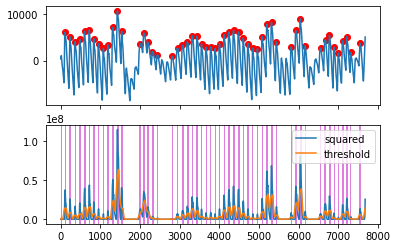

In [6]:
result = findpeaks(preprocessed[0], sampling_rate=128, show=True)
print(result)

In [7]:
print(result, len(preprocessed[0]))

{'PPG_Peaks': array([ 110,  235,  362,  483,  601,  721,  837,  953, 1075, 1190, 1311,
       1430, 1534, 2008, 2094, 2199, 2313, 2432, 2818, 2951, 3067, 3191,
       3315, 3436, 3550, 3665, 3783, 3894, 4005, 4121, 4241, 4358, 4484,
       4604, 4723, 4846, 4962, 5082, 5203, 5318, 5442, 5811, 5929, 6044,
       6167, 6558, 6681, 6779, 6895, 7004, 7110, 7218, 7321, 7550])} 7680


In [8]:
segmented = []
for PPG in preprocessed:
    for index in result['PPG_Peaks']:
        if index > 60:
            segment = PPG[index-60:index+60]
        else:
            segment = PPG[0:index+60]
            
        if len(segment) == 120:
            segmented.append(segment)

7680
54


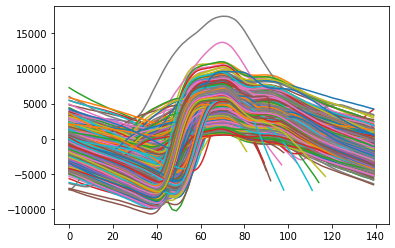

In [9]:
PPG = preprocessed[0]
result = findpeaks(preprocessed[0], sampling_rate=128)
print(len(PPG))
a = result['PPG_Peaks']
print(len(a))
for PPG in preprocessed[:40]:
    result = findpeaks(PPG, sampling_rate=128)
    a = result['PPG_Peaks']
    for idx in a:
        a = idx
        seg = PPG[a-70:a+70]
        times = list(range(0,len(seg)))
        plt.plot(times, seg)
plt.show()

In [10]:
segmented = []
index = 0
cal= 0

for PPG in preprocessed:
    tmp = []
    result = findpeaks(PPG, sampling_rate=128)
    a = result['PPG_Peaks']
    for idx in a:
        a = idx
        if a > 70:
            seg = PPG[a-70:a+70]
            times = list(range(0,len(seg)))
        else:
            seg = PPG[0:a+70]
            times = list(range(0,len(seg)))
        if len(seg) == 140:
            cal+=1
            tmp.append(seg)
            
    segmented.append(tmp)
    index += 1

In [11]:
# nm = []
# for i in segmented:
#     for j in i:
#         nm.append(j)
# segmented = nm

In [12]:
from sklearn.preprocessing import MinMaxScaler

normalized = []
index = 0
idx = 0
tmp = []
valence_data = []
arousal_data = []
for PPG in segmented:
    for segment in PPG:
        tmp.append(segment)
    if index == 39:
        tmp = np.array(tmp)
        print(tmp.shape)
        scaler = MinMaxScaler(feature_range=(0,1))
        norm = scaler.fit_transform(tmp) * 1000
        for i in norm:
            normalized.append(i)
            valence_data.append(Valence_data[idx])
            arousal_data.append(Arousal_data[idx])
        index = 0
        tmp = []
    index+=1
    idx += 1

(2296, 140)
(2614, 140)
(2984, 140)
(2131, 140)
(2532, 140)
(2848, 140)
(2841, 140)
(2436, 140)
(2741, 140)
(2575, 140)
(2679, 140)
(2471, 140)
(2012, 140)
(1711, 140)
(2393, 140)
(2697, 140)
(2539, 140)
(2204, 140)
(2145, 140)
(2235, 140)


In [13]:
train_x = normalized
train_valence = valence_data
train_arousal = arousal_data
print(len(train_valence))

49084


In [14]:
x_train_data = np.array(train_x).astype(np.float64)
y_train_data = np.array(train_valence).astype(np.float64)
print(x_train_data.shape, y_train_data.shape)

X_train = x_train_data.reshape((x_train_data.shape[0], x_train_data.shape[1], 1))
Y_train = y_train_data.reshape((y_train_data.shape[0],1))

print(f"X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}")

(49084, 140) (49084,)
X_train shape : (49084, 140, 1), Y_train shape : (49084, 1)


In [15]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras import layers, callbacks
# from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization, Conv1D,MaxPooling1D
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [16]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2 GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=3500)]) # limit in megabytes
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [17]:
# Set Hyperparameters of the model
learning_rate = 0.0001
epochs = 50
batch_size=128
print(X_train[0].shape)

(140, 1)


In [18]:
model = Sequential()
model.add(Conv1D(filters = 10, kernel_size = 2, strides = 1, input_shape = (X_train[0].shape), activation = 'relu'))
# model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))#
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv1D(filters = 20, kernel_size = 2, strides = 1, activation = 'relu'))
# model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=1, padding='valid'))#
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(700))
model.add(Dropout(0.3))
model.add(Dense(600))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 139, 10)           30        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 138, 10)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 138, 10)           40        
_________________________________________________________________
dropout (Dropout)            (None, 138, 10)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 137, 20)           420       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 136, 20)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 136, 20)           8

In [19]:
history=model.fit(X_train,
                  Y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  shuffle=True,
                  verbose=1)

Epoch 1/50
307/307 [==============================] - 9s 29ms/step - loss: 0.2083 - acc: 0.9204 - val_loss: 0.9545 - val_acc: 0.6189
Epoch 2/50
307/307 [==============================] - 9s 28ms/step - loss: 0.0513 - acc: 0.9832 - val_loss: 0.5627 - val_acc: 0.7607
Epoch 3/50
307/307 [==============================] - 9s 29ms/step - loss: 0.0359 - acc: 0.9886 - val_loss: 0.5300 - val_acc: 0.7581
Epoch 4/50
307/307 [==============================] - 9s 28ms/step - loss: 0.0307 - acc: 0.9902 - val_loss: 0.8806 - val_acc: 0.6925
Epoch 5/50
307/307 [==============================] - 9s 29ms/step - loss: 0.0275 - acc: 0.9913 - val_loss: 0.7344 - val_acc: 0.8213
Epoch 6/50
307/307 [==============================] - 8s 27ms/step - loss: 0.0263 - acc: 0.9920 - val_loss: 0.4750 - val_acc: 0.8129
Epoch 7/50
307/307 [==============================] - 8s 27ms/step - loss: 0.0250 - acc: 0.9924 - val_loss: 1.1008 - val_acc: 0.6910
Epoch 8/50
307/307 [==============================] - 9s 28ms/step - 

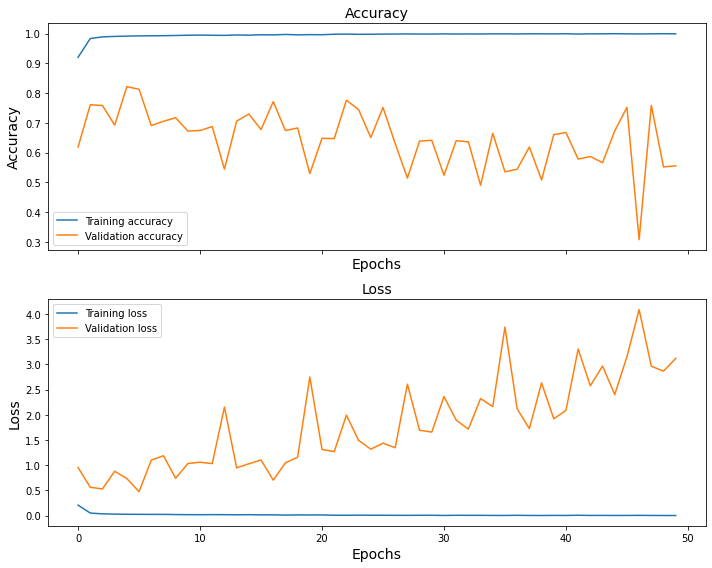

In [20]:
plt_performance(history,path='./plot_performance',filename='1DCNN_0515')

In [21]:
from tensorflow.keras.layers import LSTM, GRU


# one GRU layers with three dense layers-> IT WORKS !
model1 = Sequential()
model1.add(GRU(units=256,
              dropout=0.25,
              recurrent_dropout=0.25,
              return_sequences=False,
              input_shape=X_train[0].shape))

# Dense net
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))

callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath='BinaryClassification_Dense3-callback.h5', monitor='val_accuracy', save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=30)]

model1.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 256)               198912    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 462,081
Trainable params: 462,081
Non-trainable params: 0
________________________________________________

In [22]:
history2=model1.fit(X_train,
                  Y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=callback_list,
                  shuffle=True,
                  verbose=1)

Epoch 1/50
307/307 [==============================] - 345s 1s/step - loss: 0.4399 - acc: 0.8461 - val_loss: 0.5881 - val_acc: 0.7815
Epoch 2/50
307/307 [==============================] - 347s 1s/step - loss: 0.4319 - acc: 0.8467 - val_loss: 0.5632 - val_acc: 0.7815
Epoch 3/50
307/307 [==============================] - 342s 1s/step - loss: 0.4312 - acc: 0.8467 - val_loss: 0.5960 - val_acc: 0.7815
Epoch 4/50
307/307 [==============================] - 340s 1s/step - loss: 0.4295 - acc: 0.8467 - val_loss: 0.5837 - val_acc: 0.7815
Epoch 5/50
307/307 [==============================] - 340s 1s/step - loss: 0.4305 - acc: 0.8467 - val_loss: 0.6282 - val_acc: 0.7249
Epoch 6/50
307/307 [==============================] - 340s 1s/step - loss: 0.4289 - acc: 0.8468 - val_loss: 0.5990 - val_acc: 0.7798
Epoch 7/50
307/307 [==============================] - 340s 1s/step - loss: 0.4272 - acc: 0.8469 - val_loss: 0.6037 - val_acc: 0.7807
Epoch 8/50
307/307 [==============================] - 341s 1s/step - 

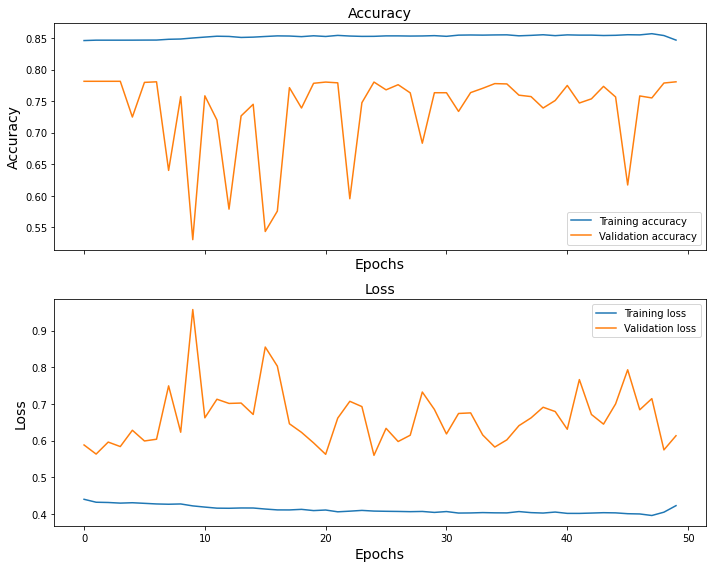

In [23]:
plt_performance(history2,path='./plot_performance',filename='GRU_performance0515')